In [47]:
#Bidirectional LSTM for streamflow problem with window regression framing
import numpy 
import pandas as pd
from pandas import read_csv
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
import tensorflow as tf 
from sklearn.metrics import mean_squared_error
from keras.layers import Bidirectional,GRU, SimpleRNN
from keras.layers import BatchNormalization, Dropout
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as geek

In [49]:
#RNN_Method = "E2KFold/E2S3KF-sRNN-10"
RNN_Method = "/content/gdrive/My Drive/Colab Notebooks/E2KFold/E2S3KF-biLSTM-10"
Var_LRs=[1e-1] #,1e-5,1e-6,1e-7,1e-8,1esimplsimpleRNNsRNN1e-5,1e-7] #,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9]
Var_Decays=[1e-1]#,1e-2,1e-3,1e-4,1e-5,1e-7]
Var_epochs=[50]#,100,300,500]
Method="LSTM"
from google.colab import drive 
drive.mount('/content/gdrive')

Streamflow = pd.read_csv('/content/gdrive/My Drive/Ermenek2S3KF.csv', names = ["SFt-1", "Rain", "Temp", "Hum", "Buh", "DMQ", "SFt", "Order"])

#Streamflow = pd.read_csv('Monthly.csv', names = ["SFt", "Pt", "SSH", "Tmean", "Pmean", "Rhmean", "Month"])
print(Streamflow.shape)
Streamflow.head(9)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
(1947, 8)


,SFt-1,Rain,Temp,Hum,Buh,DMQ,SFt,Order
0,0.347490,0.0,2.328266,1.629347,0.001039,0.779187,0.345387,1
1,0.345471,0.0,2.340392,1.644914,0.001039,0.581809,0.172820,2
2,0.172862,0.0,2.352518,1.639725,0.001039,0.769656,0.518207,3
3,0.518332,0.0,2.364645,1.644914,0.001039,1.163618,2.937935,4
4,2.938647,0.0,2.255507,1.577457,0.001039,0.769259,1.382305,5
5,1.382640,0.0,2.291886,1.655292,0.001039,0.742651,1.382305,6
6,1.382640,0.0,2.364645,1.826530,0.001039,1.121124,2.109662,7
7,2.110173,0.0,2.279760,1.608591,0.001039,0.882046,1.832141,8
8,1.832585,0.0,2.109991,1.520378,0.001039,0.615566,0.623412,9


In [38]:
import numpy as np
#HA_Speed_Up import matplotlib.pyplot as plt
x= Streamflow.drop('SFt',axis=1)
x= x.drop('Order',axis=1)
Y= Streamflow['SFt']

In [39]:
X=np.array(x)
y=np.array(Y)

In [40]:
'''
#Tradional method
train_size_y = int(len(y) * 0.70)
train_size_X = int(len(X) * 0.70)
y_train, y_test = y[0:train_size_y], y[train_size_y:len(y)]
X_train, X_test = X[0:train_size_X], X[train_size_X:len(X)]

print(X_train[0:3], X_test[0:3],y_train[0:3], y_test[0:3] )

# reshape input to be [samples, time steps, features]
X_train = numpy.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = numpy.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

input=X_train[1:]
input_shape=X_train.shape[1:]
print (input_shape)
print (X_train.shape[1:])
'''

'\n#Tradional method\ntrain_size_y = int(len(y) * 0.70)\ntrain_size_X = int(len(X) * 0.70)\ny_train, y_test = y[0:train_size_y], y[train_size_y:len(y)]\nX_train, X_test = X[0:train_size_X], X[train_size_X:len(X)]\n\nprint(X_train[0:3], X_test[0:3],y_train[0:3], y_test[0:3] )\n\n# reshape input to be [samples, time steps, features]\nX_train = numpy.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))\nX_test = numpy.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))\n\ninput=X_train[1:]\ninput_shape=X_train.shape[1:]\nprint (input_shape)\nprint (X_train.shape[1:])\n'

In [41]:
train_size = 1363 # round(len(X) * 0.70)
test_size = 584 #len(X)-train_size
print(train_size,test_size)

1363 584


In [42]:
startTime = datetime.now()
fileOfSummary = open(RNN_Method+'_Summary_'+str(datetime.now()).replace(":", ".")+'.csv', "w")
fileOfSummary.write("Method,LR,DE,Epoch,RunTime,CCTr,CCTt,NSTr,NSTt,RMSETr,RMSETt,MAETr,MAETt,MAPETr,MAPETt\n")

87

In [43]:
TrainSet= np.array([[0,1363,0,0],[194,1557,0,0],[388,1751,0,0],[582,1945,0,0],[776,1947,0,192],
                    [970,1947,0,386],[1164,1947,0,580],[1358,1947,0,774],[1552,1947,0,968],[1746,1947,0,1162]])

TestSet= np.array([[1363,1947,0,0],[1557,1947,0,194],[1751,1947,0,388],[1945,1947,0,582],[0,0,192,776],
                   [0,0,386,970],[0,0,580,1164],[0,0,774,1358],[0,0,968,1552],[0,0,1162,1746]])
                   
print (TrainSet[1][0])          
print (TestSet[1][0]) 

194
1557


In [44]:
'''
x1= Streamflow['Order']
for e_set in range(10):
    X_train=np.concatenate( (x1[TrainSet[e_set][0]: TrainSet[e_set][1]], x1[TrainSet[e_set][2]: TrainSet[e_set][3]]) , axis=0)
    X_test=np.concatenate( (x1[TestSet[e_set][0]: TestSet[e_set][1]], x1[TestSet[e_set][2]: TestSet[e_set][3]]) , axis=0)
    
    Y_train=np.concatenate( (x1[TrainSet[e_set][0]: TrainSet[e_set][1]], x1[TrainSet[e_set][2]: TrainSet[e_set][3]]) , axis=0)
    Y_test=np.concatenate( (x1[TestSet[e_set][0]: TestSet[e_set][1]], x1[TestSet[e_set][2]: TestSet[e_set][3]]) , axis=0)

    print (e_set)
    print (len(X_train), " - ", X_train[0:5] , " - ", X_train[-5:])
    print (len(X_test), " - ", X_test[0:5] , " - ", X_test[-5:])
    print (len(Y_train), " - ", Y_train[0:5] , " - ", Y_train[-5:])
    print (len(Y_test), " - ", Y_test[0:5] , " - ", Y_test[-5:])
    print ("")
'''

'\nx1= Streamflow[\'Order\']\nfor e_set in range(10):\n    X_train=np.concatenate( (x1[TrainSet[e_set][0]: TrainSet[e_set][1]], x1[TrainSet[e_set][2]: TrainSet[e_set][3]]) , axis=0)\n    X_test=np.concatenate( (x1[TestSet[e_set][0]: TestSet[e_set][1]], x1[TestSet[e_set][2]: TestSet[e_set][3]]) , axis=0)\n    \n    Y_train=np.concatenate( (x1[TrainSet[e_set][0]: TrainSet[e_set][1]], x1[TrainSet[e_set][2]: TrainSet[e_set][3]]) , axis=0)\n    Y_test=np.concatenate( (x1[TestSet[e_set][0]: TestSet[e_set][1]], x1[TestSet[e_set][2]: TestSet[e_set][3]]) , axis=0)\n\n    print (e_set)\n    print (len(X_train), " - ", X_train[0:5] , " - ", X_train[-5:])\n    print (len(X_test), " - ", X_test[0:5] , " - ", X_test[-5:])\n    print (len(Y_train), " - ", Y_train[0:5] , " - ", Y_train[-5:])\n    print (len(Y_test), " - ", Y_test[0:5] , " - ", Y_test[-5:])\n    print ("")\n'

In [45]:
for e_LR in Var_LRs:
    for e_decay in Var_Decays:

        for e_epoch in Var_epochs:

            def create_LSTM():
                model = Sequential()
                #https://keras.io/layers/recurrent/#simplernn
                model.add(Bidirectional(LSTM(250, input_shape=(1, 6), activation='relu',return_sequences=True)))
                #model.add(Bidirectional(LSTM(200, input_shape=X_train.shape[1:], activation='relu',return_sequences=True)))
                model.add(Dropout(0.01))
                #model.add(BatchNormalization())

                model.add(Bidirectional(LSTM(200, activation='relu')))

                model.add(Dropout(0.010))
                #model.add(BatchNormalization())

                model.add(Dense(100, activation='relu'))
                model.add(Dropout(0.010))

                model.add(Dense(1, activation='relu'))

                return model
                #https://stackoverflow.com/questions/42763094/how-to-save-final-model-using-keras
            model = create_LSTM()
            
            optimizer = tf.keras.optimizers.Adam(lr=e_LR, decay=e_decay)
            model.compile(optimizer=optimizer,loss='mean_squared_error')

            print(" ")
            print(" ")
            print("LRs:",e_LR)
            print("Decays:",e_decay)
            print("epochs:",e_epoch)


            for e_set in range(1):

                X_train=np.concatenate( (X[TrainSet[e_set][0]: TrainSet[e_set][1]], X[TrainSet[e_set][2]: TrainSet[e_set][3]]) , axis=0)
                X_test=np.concatenate( (X[TestSet[e_set][0]: TestSet[e_set][1]], X[TestSet[e_set][2]: TestSet[e_set][3]]) , axis=0)

                y_train=np.concatenate( (y[TrainSet[e_set][0]: TrainSet[e_set][1]], y[TrainSet[e_set][2]: TrainSet[e_set][3]]) , axis=0)
                y_test=np.concatenate( (y[TestSet[e_set][0]: TestSet[e_set][1]], y[TestSet[e_set][2]: TestSet[e_set][3]]) , axis=0)

                X_train = numpy.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
                X_test = numpy.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
                #print(X_train.shape)
                #print(X_test.shape)
                #print(y_train.shape)
                #print(y_test.shape)
                
                history = model.fit(X_train, y_train, epochs=e_epoch, batch_size=512, verbose=0, validation_data=(X_test, y_test))

            hist_df = pd.DataFrame(history.history) 
            Time_elasped= datetime.now() - startTime
            print('\nTime elasped: ', Time_elasped)

            Train = model.predict(X_train)
            Test = model.predict(X_test)

            #scores = model.evaluate(X_test, Test, verbose=0)
            #print('accuracy:', scores*100)
            
            FileName=RNN_Method+'-LR'+str(e_LR)+'-DE'+str(e_decay)+'-'+str(e_epoch)
            np.savetxt(FileName+'_Train.csv', Train)
            np.savetxt(FileName+'_Test.csv', Test)
            #with open(FileName+'_History.csv', mode='w') as f:
            #    hist_df.to_csv(f)

            #model.save(FileName+'_Model.h5')
            Train = geek.asarray(Train)# np.loadtxt(FileName+'_Train.csv')
            Test = geek.asarray(Test)#np.loadtxt(FileName+'_Test.csv')

            Train = Train.reshape(Train.shape[0])
            Test = Test.reshape(Test.shape[0])

            print(" ")
            print("LRs:",e_LR)
            print("Decays:",e_decay)
            print("epochs:",e_epoch)
            print("Train ==>")
            CC_Train=np.corrcoef(y_train,Train)
            print("CC_Train = %.3f" %CC_Train[0,1])

            NSTr=1 - sum((Train-y_train)**2)/sum((y_train-np.mean(y_train))**2)
            print("NSTr = %.2f" %NSTr)

            rootMeanSquaredErrorTr = sqrt(mean_squared_error(y_train, Train))
            print("RMSE = %.2f" % rootMeanSquaredErrorTr)
            MAETr=mean_absolute_error(y_train, Train)
            print("MAE = %.2f" %  MAETr)

            MAPETr=np.mean(np.abs((y_train - Train) / y_train)) * 100
            print("MAPE = %.2f" %MAPETr)

            print("Test ==>")
            CC_Test=np.corrcoef(y_test,Test)
            print("CC_Test = %.3f" %CC_Test[0,1])

            NSTt=1 - sum((Test-y_test)**2)/sum((y_test-np.mean(y_test))**2)
            print("NSTt = %.2f" %NSTt)

            rootMeanSquaredErrorTt = sqrt(mean_squared_error(y_test, Test))
            print("RMSE = %.2f" % rootMeanSquaredErrorTt)
            MAETt=mean_absolute_error(y_test, Test)
            print("MAE = %.2f" %  MAETt)

            MAPETt=np.mean(np.abs((y_test - Test) / y_test)) * 100
            print("MAPE = %.2f" %MAPETt)
            fileOfSummary.write(RNN_Method+','+str(e_LR)+','+str(e_decay)+','+str(e_epoch)+','+str(Time_elasped)+','+str(CC_Train[0,1])+','+str(CC_Test[0,1])+','+str(NSTr)+','+str(NSTt)+','+str(rootMeanSquaredErrorTr)+','+str(rootMeanSquaredErrorTt)+','+str(MAETr)+','+str(MAETt)+','+str(MAPETr)+','+str(MAPETt)+'\n')
            del model


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 
 
LRs: 0.1
Decays: 0.1
epochs: 50

Time elasped:  0:00:25.791994
 
LRs: 0.1
Decays: 0.1
epochs: 50
Train ==>
CC_Train = 0.863
NSTr = 0.75
RMSE = 0.53
MAE = 0.29
MAPE = 121.29
Test ==>
CC_Test = 0.866
NSTt = 0.73
RMSE = 0.46
MAE = 0.31
MAPE = 89.00


Text(0, 0.5, 'Loss')

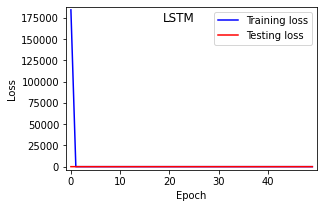

In [50]:
plt.figure(figsize=(4.5, 3))
plt.rcParams["font.size"] =10
#plt.rcParams["font.family"] = {'serif'}
plt.plot(history.history['loss'],'b' ,label="Training loss")
plt.plot(history.history['val_loss'],'r', label="Testing loss")
#plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.legend()
plt.margins(0.02,0.02)
plt.title(Method, position=(0.45, .87))
plt.xlabel('Epoch')
plt.ylabel('Loss')


In [51]:
fileOfSummary.close()
print("Summary file is written")
print("Finished")

Summary file is written
Finished
